## Potato Disease Classification Using Deep Learning

In this project, we will use deep learning to classify tomato diseases. The dataset contains  leaf images  of three categories: healthy leaves, Early_blight leaves, and Late_blight leaves. The dataset is downloaded from Kaggle.

At the end of the first part of the lesson,each student will be abble to:
1. Read multiple images in a folder
2. Understand tensorflow and keras
3. Use the matplotlib library to plot images
4. Do data preprocessing


In [36]:
# Import librabries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflowjs as tfjs
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import itertools

In [37]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [38]:
images_dataset=tf.keras.preprocessing.image_dataset_from_directory(
 'Potato_ds',
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE,
 
)

Found 2152 files belonging to 3 classes.


In [39]:
class_names=images_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [61]:
dataset_length = len(images_dataset)
print(dataset_length)

68


In [62]:
# Exploring the dataset
for image_batch, label_batch in images_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0]


In [63]:
# Print first image in that batch
for image_batch, label_batch in images_dataset.take(1):
    first_image = image_batch[0].numpy()
    print(first_image)

[[[197. 200. 207.]
  [197. 200. 207.]
  [196. 199. 206.]
  ...
  [198. 201. 210.]
  [198. 201. 210.]
  [198. 201. 210.]]

 [[197. 200. 207.]
  [197. 200. 207.]
  [197. 200. 207.]
  ...
  [196. 199. 208.]
  [196. 199. 208.]
  [196. 199. 208.]]

 [[197. 200. 207.]
  [197. 200. 207.]
  [199. 202. 209.]
  ...
  [193. 196. 205.]
  [193. 196. 205.]
  [193. 196. 205.]]

 ...

 [[154. 148. 160.]
  [135. 129. 141.]
  [151. 145. 157.]
  ...
  [148. 145. 156.]
  [151. 148. 159.]
  [156. 153. 164.]]

 [[160. 154. 166.]
  [150. 144. 156.]
  [149. 143. 155.]
  ...
  [154. 151. 162.]
  [156. 153. 164.]
  [159. 156. 167.]]

 [[159. 153. 165.]
  [165. 159. 171.]
  [145. 139. 151.]
  ...
  [158. 155. 166.]
  [155. 152. 163.]
  [153. 150. 161.]]]


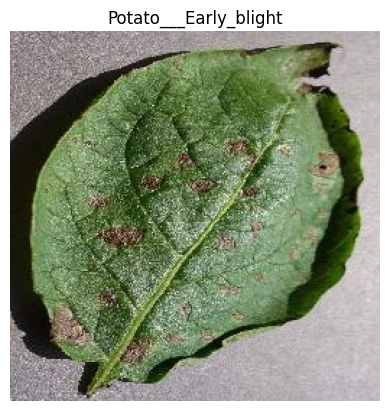

In [65]:
# Visualize the first image in that batch
for image_batch, label_batch in images_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    plt.imshow(first_image)
    plt.title(class_names[label_batch[0]])
    plt.axis('off')
    plt.show()

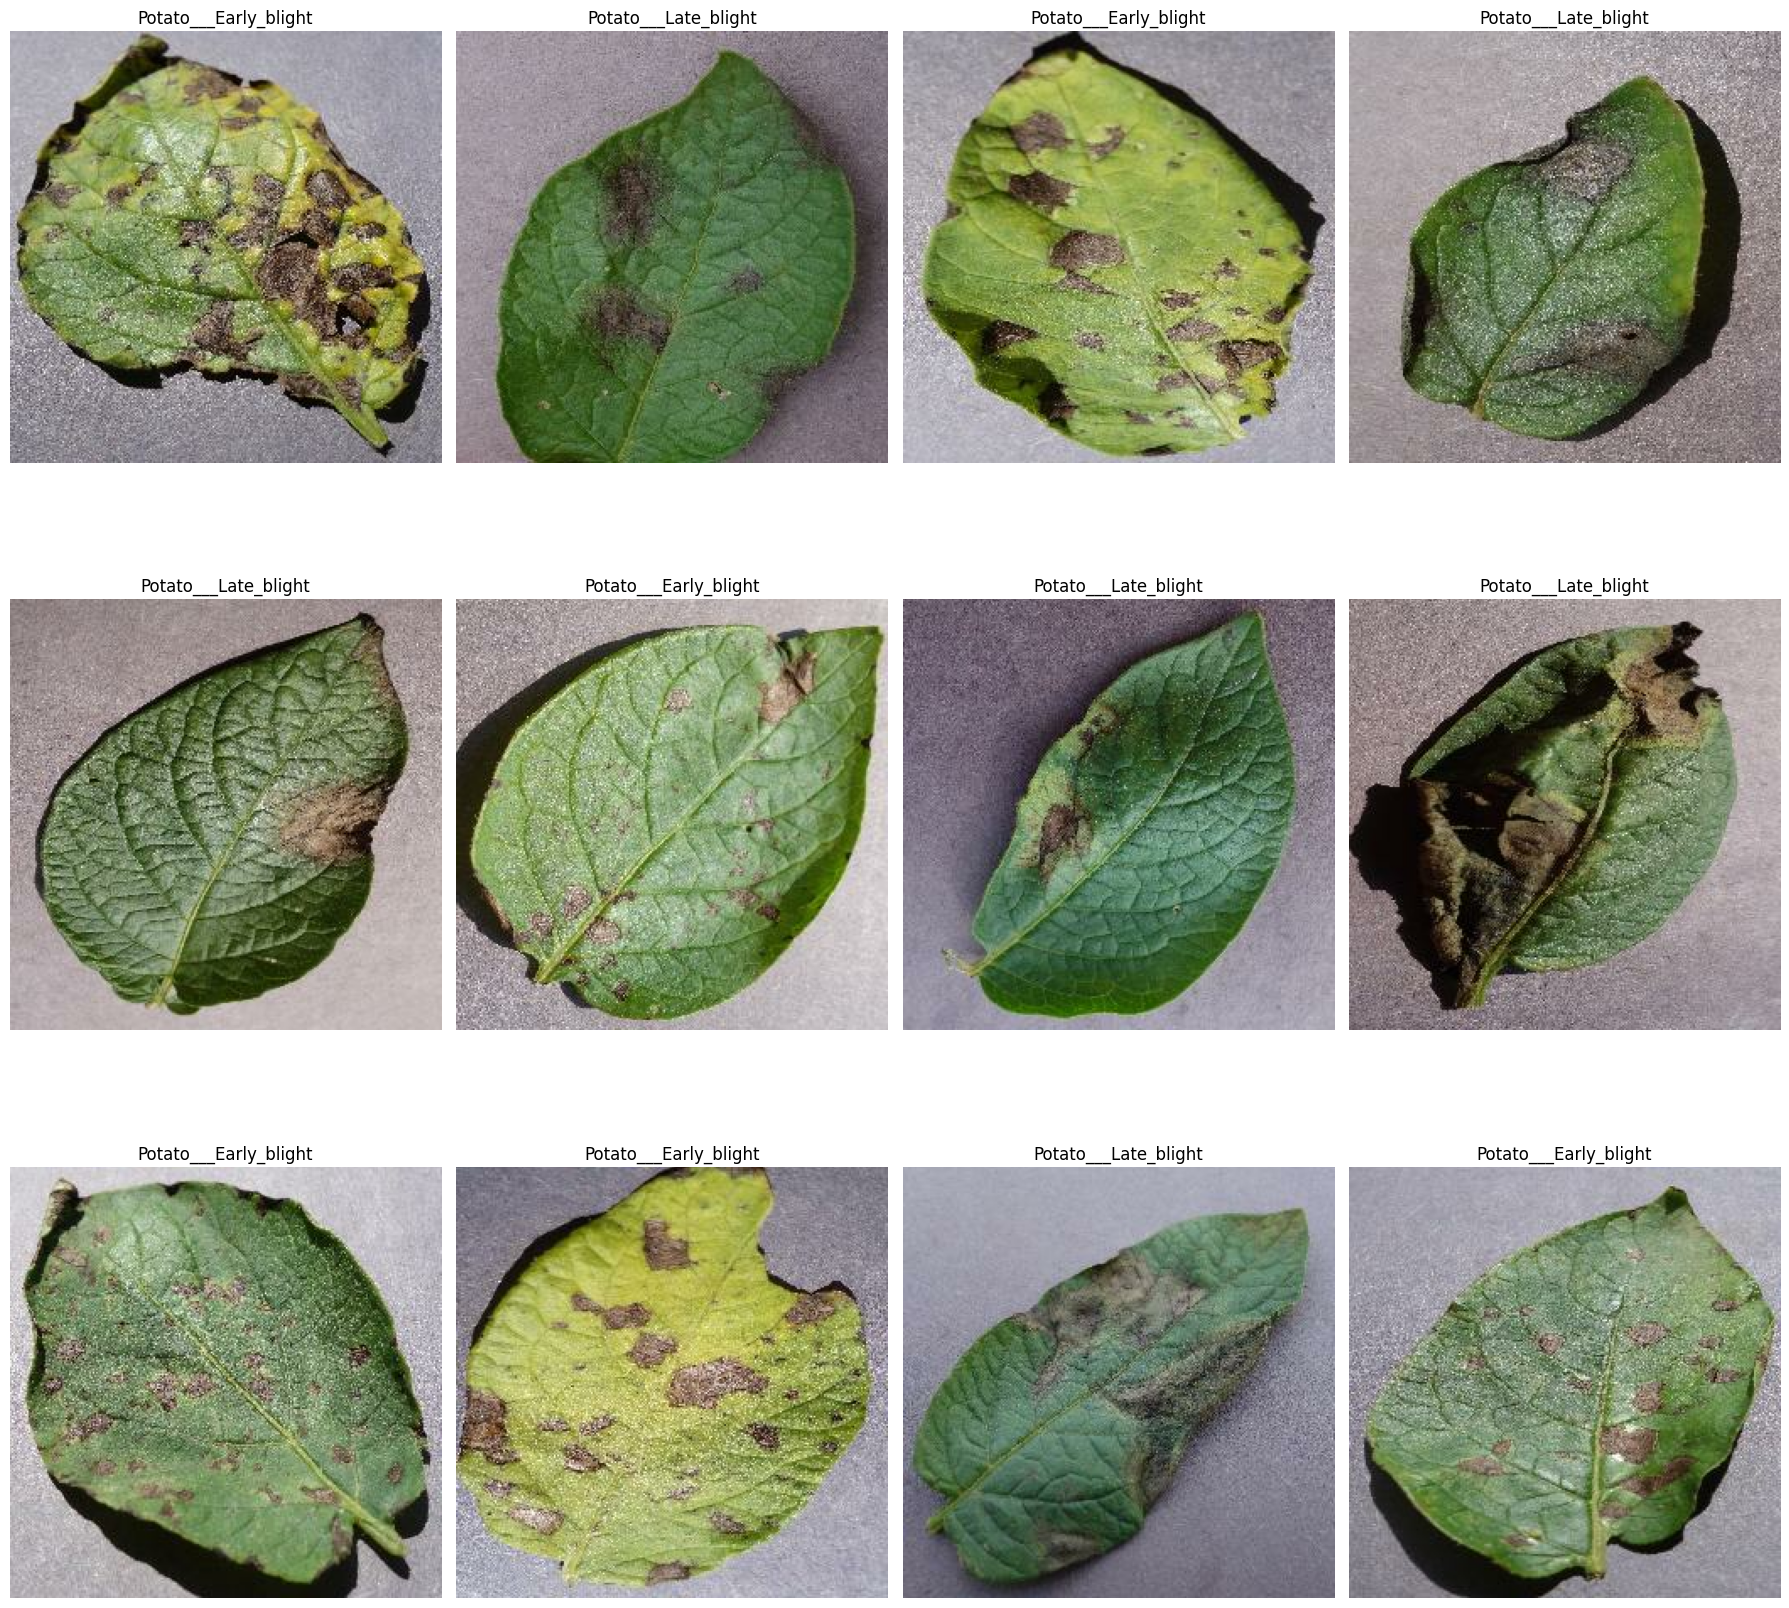

In [66]:
# Visualize the first image in that batch
plt.figure(figsize=(18, 18))

for image_batch, label_batch in images_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [67]:
dataset_length = len(images_dataset)
print(dataset_length)

68


In [68]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split* ds_size)
    val_size=int(val_split* ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [69]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(images_dataset)

In [70]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [71]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [73]:
def resize_and_rescale(image):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize the image
    image = image / 255.0  # Rescale pixel values to the range of 0-1
    return image

In [75]:
def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random vertical flip
    image = tf.image.random_rotation(image, 0.2)  # Random rotation
    return image

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 128)    

In [77]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 89s 2s/step - loss: 46.3355 - accuracy: 0.6499 - val_loss: 0.8830 - val_accuracy: 0.6562
Epoch 2/10
54/54 [==============================] - 76s 1s/step - loss: 0.6918 - accuracy: 0.7760 - val_loss: 0.5691 - val_accuracy: 0.8125
Epoch 3/10
54/54 [==============================] - 73s 1s/step - loss: 0.5518 - accuracy: 0.8322 - val_loss: 0.5698 - val_accuracy: 0.8125
Epoch 4/10
54/54 [==============================] - 69s 1s/step - loss: 0.5012 - accuracy: 0.8374 - val_loss: 0.5632 - val_accuracy: 0.8177
Epoch 5/10
54/54 [==============================] - 67s 1s/step - loss: 0.3767 - accuracy: 0.8819 - val_loss: 0.5111 - val_accuracy: 0.8802
Epoch 6/10
54/54 [==============================] - 67s 1s/step - loss: 0.2520 - accuracy: 0.9196 - val_loss: 0.4503 - val_accuracy: 0.8958
Epoch 7/10
54/54 [==============================] - 68s 1s/step - loss: 0.2480 - accuracy: 0.9248 - val_loss: 0.3843 - val_accuracy: 0.8490
Epoch 8/10
54/54 [============

In [83]:
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

8/8 [==============================] - 2s 286ms/step - loss: 0.5115 - accuracy: 0.9102
Test Loss: 0.5114930272102356
Test Accuracy: 0.91015625


In [84]:
scores

[0.5114930272102356, 0.91015625]

In [85]:
history

In [86]:
print(history.params)

{'verbose': 1, 'epochs': 10, 'steps': 54}


In [88]:
print("Number of epochs:", history.params['epochs'])

Number of epochs: 10


In [89]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [90]:
len(history.history['accuracy'])

10

In [95]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

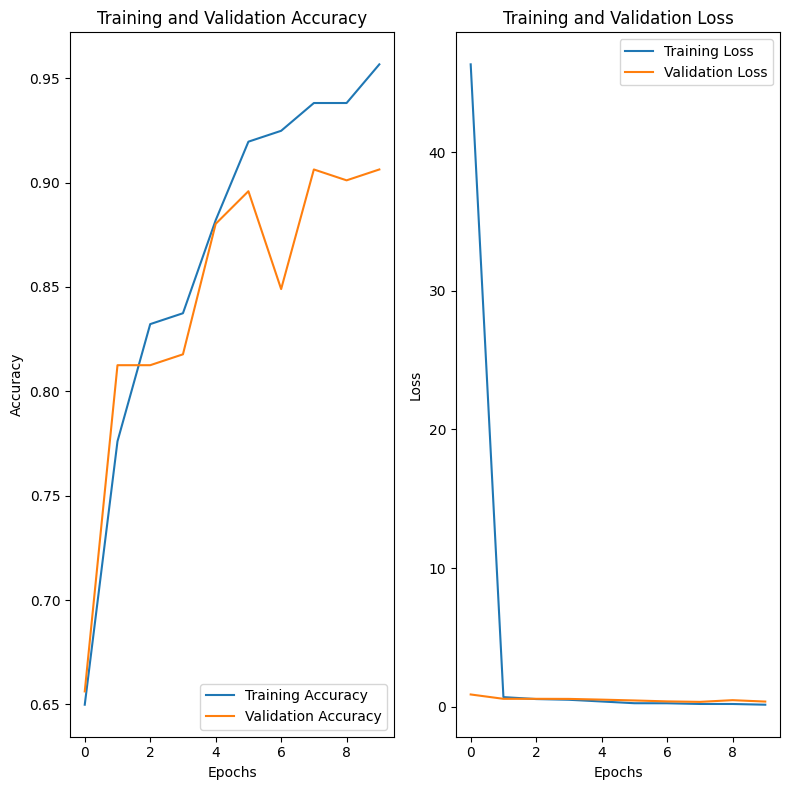

In [97]:
plt.figure(figsize=(8, 8))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 477ms/step


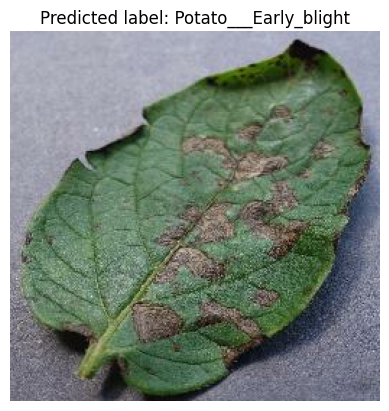

In [100]:
# Making predictions
for images_batch, label_batch in test_ds.take(1):
    predictions = model.predict(images_batch)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    plt.title(f"Predicted label: {class_names[predicted_labels[0]]}")
    plt.axis('off')
    plt.show()

Prediction for the first image:
True Label:  Potato___Early_blight
1/1 [==============================] - 0s 434ms/step
Predicted Label:  Potato___Early_blight


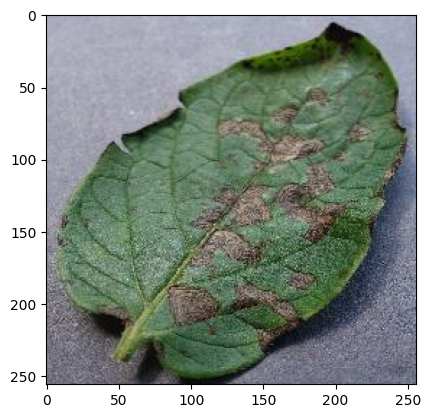

In [101]:
# Making predictions
for images_batch, label_batch in test_ds.take(1):
    image1 = images_batch[0].numpy().astype('uint8')
    label1 = label_batch[0].numpy()

    print("Prediction for the first image:")
    plt.imshow(image1)
    print('True Label: ', class_names[label1])

    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    print("Predicted Label: ", class_names[predicted_label])

In [106]:
# Function to predict with confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


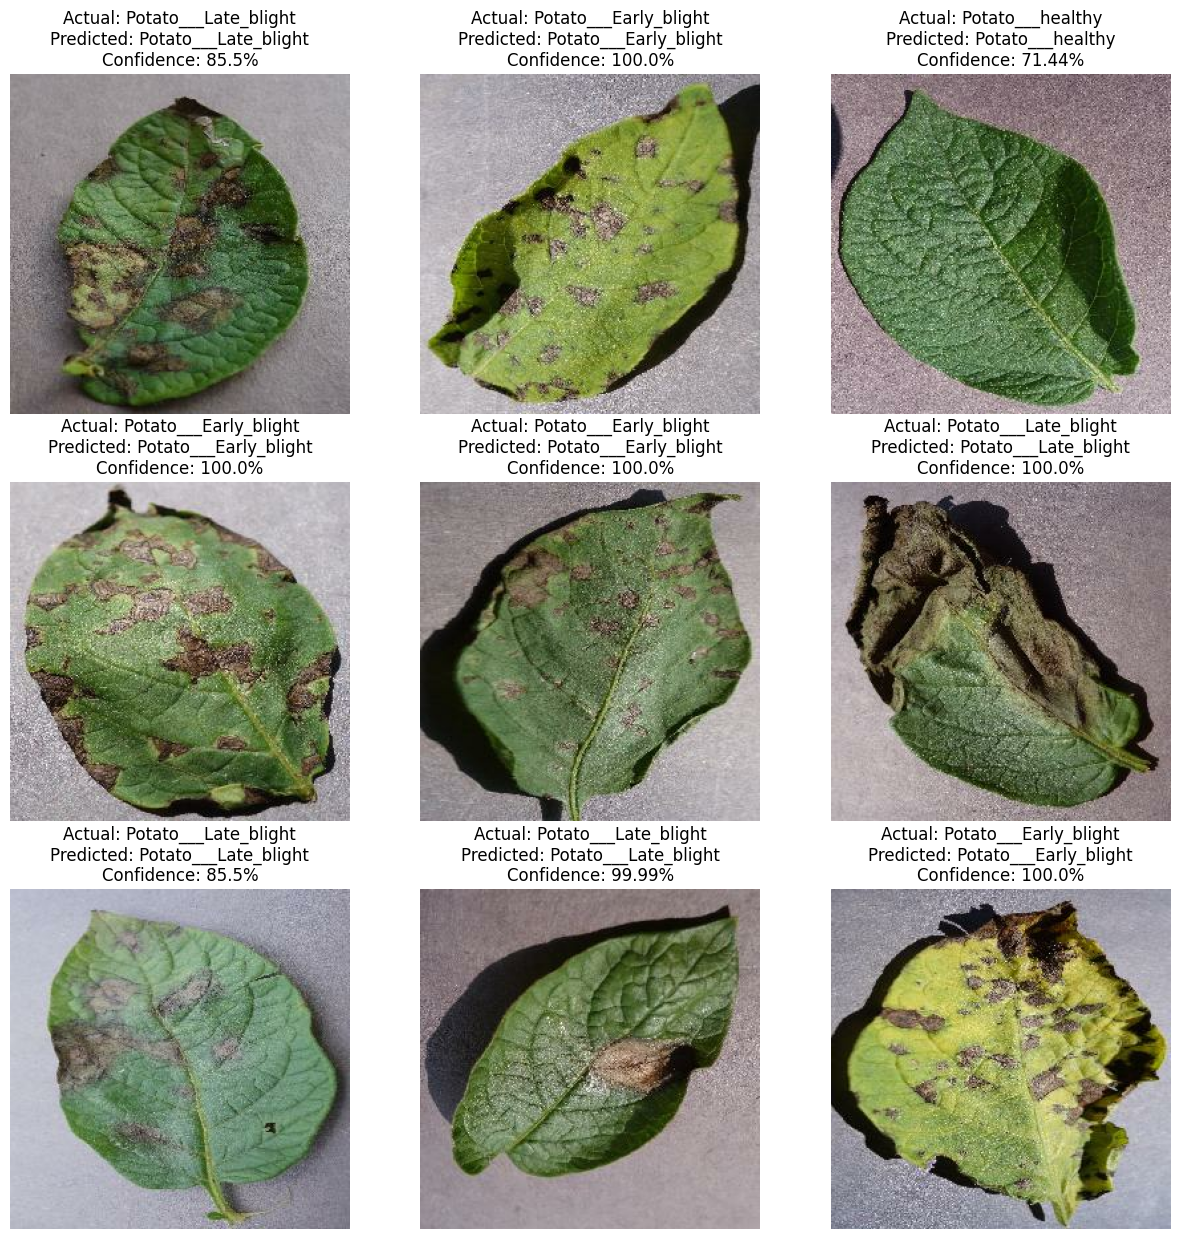

In [107]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.show()

In [108]:
# Saving the model
model_version=2
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [109]:
import os

saved_models_dir = "../saved_models"
existing_versions = [int(i) for i in os.listdir(saved_models_dir) if i.isdigit()]
model_version = max(existing_versions + [0]) + 1

model.save(f"{saved_models_dir}/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/9\assets


INFO:tensorflow:Assets written to: ../saved_models/9\assets


In [110]:
model.save("../Potato.h5")

In [111]:
import tensorflowjs as tfjs

# Load the model
model = tf.keras.models.load_model('../Potato.h5')

# Save the model as TensorFlow.js model
tfjs.converters.save_keras_model(model, 'models')